In [10]:
# Step 1: Upload your Kaggle API key (kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raybeckhamonyango","key":"6dd420facfb86ed37c81735ec1a764c3"}'}

In [11]:
# Step 2: Setup Kaggle credentials
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [12]:

# Step 3: Install and download dataset from Kaggle
!pip install -q kaggle
!kaggle datasets download -d asdasdasasdas/garbage-classification
!unzip -q garbage-classification.zip -d /content/garbage

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
garbage-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/garbage/Garbage classification/Garbage classification/cardboard/cardboard1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [13]:
# Step 4: Install TensorFlow and TensorFlow Hub
!pip install -q tensorflow tensorflow_hub

In [14]:
# Step 5: Import required libraries
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os

In [15]:
# Step 6: Load and preprocess dataset
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

dataset_path = "/content/garbage/Garbage classification/Garbage classification"

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Classes:", class_names)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [16]:
# Step 7: Load MobileNetV2 feature extractor
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, trainable=False)

In [17]:

# Step 8: Build the model
def build_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.layers.Lambda(lambda img: feature_extractor_layer(img))(inputs)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

model = build_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,686 (30.02 KB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Step 9: Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.3387 - loss: 1.6775 - val_accuracy: 0.5584 - val_loss: 1.1619
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 813ms/step - accuracy: 0.5911 - loss: 1.0961 - val_accuracy: 0.5980 - val_loss: 1.0399
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 806ms/step - accuracy: 0.6510 - loss: 0.9777 - val_accuracy: 0.6238 - val_loss: 0.9899
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 835ms/step - accuracy: 0.6823 - loss: 0.9190 - val_accuracy: 0.6634 - val_loss: 0.9442
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 818ms/step - accuracy: 0.7165 - loss: 0.8247 - val_accuracy: 0.6594 - val_loss: 0.9316


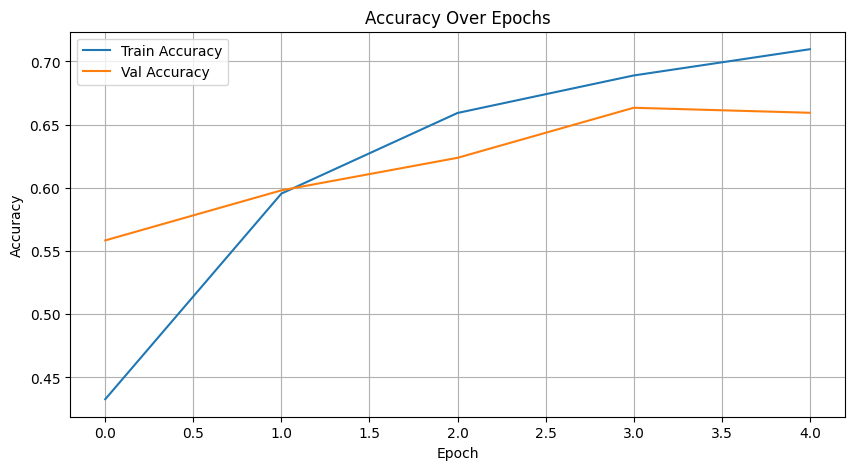

In [19]:
# Step 10: Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Step 11: Evaluate the model
loss, acc = model.evaluate(val_ds)
print(f"✅ Final Validation Accuracy: {acc:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 679ms/step - accuracy: 0.6553 - loss: 0.9244
✅ Final Validation Accuracy: 0.66


In [21]:
# Step 12: Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("/content/edge_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TensorFlow Lite model saved: edge_model.tflite")

Saved artifact at '/tmp/tmpvie0ng4l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140709015281232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140709015059728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140709015163088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140709015281040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140709015044176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140709015047248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140709015169616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140709015276048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140709015280848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140709015057232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14070803569998